<a href="https://colab.research.google.com/github/AnLiMan/RNN/blob/main/RNN_2_v_0_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключение гугл диска

In [1]:
from google.colab import drive
drive.mount('/content/drive')
number_of_interations = 1
print('Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака: ', number_of_interations)

Mounted at /content/drive
Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака:  1


Библиотеки

In [2]:
from pandas import read_csv
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

Keras SimpleRNN
The function below returns a model that includes a SimpleRNN layer and a Dense layer for learning sequential data. The input_shape specifies the parameter (time_steps x features). We’ll simplify everything and use univariate data, i.e., one feature only; the time_steps are discussed below.

In [31]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation = activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

demo_model = create_RNN(6, 1, (6,1), activation=['linear', 'linear'])

In [32]:
wx = demo_model.get_weights()[0]
wh = demo_model.get_weights()[1]
bh = demo_model.get_weights()[2]
wy = demo_model.get_weights()[3]
by = demo_model.get_weights()[4]
 
print('wx = ', wx, ' wh = ', wh, ' bh = ', bh, ' wy =', wy, 'by = ', by)

wx =  [[ 0.75716484 -0.44369814  0.44318533  0.4266894   0.1177417  -0.274931  ]]  wh =  [[ 0.35811174  0.56230634 -0.3932366  -0.4207156  -0.17675324 -0.43896374]
 [-0.15257926 -0.0739892   0.1983868   0.46414074 -0.5946379  -0.60238445]
 [-0.65471494 -0.15362322  0.00835292 -0.41091642  0.36853704 -0.49295706]
 [-0.18383195 -0.37856495 -0.18617305 -0.5133686  -0.6633313   0.29099533]
 [ 0.6206167  -0.6326513   0.18870898 -0.2115743   0.15402018 -0.33240086]
 [-0.02940465 -0.3334338  -0.85771     0.36112118  0.12495521 -0.07917437]]  bh =  [0. 0. 0. 0. 0. 0.]  wy = [[ 0.5016179 ]
 [ 0.3590461 ]
 [ 0.6168009 ]
 [-0.69956625]
 [-0.6403626 ]
 [ 0.79588187]] by =  [0.]


In [33]:
x = np.array([1, 2, 3, 4, 5, 6])
# Reshape the input to the required sample_size x time_steps x features 
x_input = np.reshape(x,(1, 6, 1))
y_pred_model = demo_model.predict(x_input)
 
m = 6
h0 = np.zeros(m)
h1 = np.dot(x[0], wx) + h0 + bh
h2 = np.dot(x[1], wx) + np.dot(h1,wh) + bh
h3 = np.dot(x[2], wx) + np.dot(h2,wh) + bh
h4 = np.dot(x[3], wx) + np.dot(h3,wh) + bh
h5 = np.dot(x[4], wx) + np.dot(h4,wh) + bh
h6 = np.dot(x[5], wx) + np.dot(h5,wh) + bh
o7 = np.dot(h6, wy) + by
 
print('h1 = ', h1,'h2 = ', h2,'h3 = ', h3, 'h4 = ', h4, 'h5 = ', h5, 'h6 = ', h6)
 
print("Prediction from network ", y_pred_model)
print("Prediction from our computation ", o7)

h1 =  [[ 0.75716484 -0.44369814  0.44318533  0.42668939  0.1177417  -0.27493101]] h2 =  [[ 1.56573594 -0.64124017  0.6828957  -0.19646626  0.22956612 -0.72662975]] h3 =  [[ 2.68289649 -0.3367121   1.2954774  -0.16701219  0.78433812 -1.53840778]] h4 =  [[ 3.75535477 -0.36031562  2.16036254 -0.7463522   0.71376559 -2.9007149 ]] h5 =  [[ 4.43668856  0.38612118  3.44736397 -1.31682525  1.17792196 -4.09581611]] h6 =  [[ 4.90941306  0.39339889  5.00030479 -1.59609886  1.50625175 -5.97957589]]
Prediction from network  [[1.0810838]]
Prediction from our computation  [[1.08108392]]


In [34]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

dataset_url = 'https://raw.githubusercontent.com/AnLiMan/RNN/main/TestDataset4.csv' 
train_data, test_data, data = get_train_test(dataset_url)

In [35]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
time_steps = 12
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [36]:
model = create_RNN(hidden_units=6, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2, shuffle = True)
model.summary()

# Сохраним всю модель в  HDF5 файл
model.save("/content/drive/My Drive/Files for colab/RNN_Model" + str(number_of_interations) + ".h5")

Epoch 1/20
60/60 - 1s - loss: 0.1266
Epoch 2/20
60/60 - 0s - loss: 0.1219
Epoch 3/20
60/60 - 0s - loss: 0.1174
Epoch 4/20
60/60 - 0s - loss: 0.1121
Epoch 5/20
60/60 - 0s - loss: 0.1113
Epoch 6/20
60/60 - 0s - loss: 0.1100
Epoch 7/20
60/60 - 0s - loss: 0.1086
Epoch 8/20
60/60 - 0s - loss: 0.1066
Epoch 9/20
60/60 - 0s - loss: 0.1049
Epoch 10/20
60/60 - 0s - loss: 0.1018
Epoch 11/20
60/60 - 0s - loss: 0.1019
Epoch 12/20
60/60 - 0s - loss: 0.0992
Epoch 13/20
60/60 - 0s - loss: 0.0986
Epoch 14/20
60/60 - 0s - loss: 0.0958
Epoch 15/20
60/60 - 0s - loss: 0.0971
Epoch 16/20
60/60 - 0s - loss: 0.0963
Epoch 17/20
60/60 - 0s - loss: 0.0926
Epoch 18/20
60/60 - 0s - loss: 0.0925
Epoch 19/20
60/60 - 0s - loss: 0.0943
Epoch 20/20
60/60 - 0s - loss: 0.0916
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 6)                 48        
_____________________________

In [37]:
# Восстановим в точности ту же модель, включая веса и оптимизатор

Loading_model = keras.models.load_model("/content/drive/My Drive/Files for colab/RNN_Model" + str(number_of_interations) + ".h5")
Loading_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 6)                 48        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


In [38]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.297 RMSE
Test RMSE: 0.346 RMSE


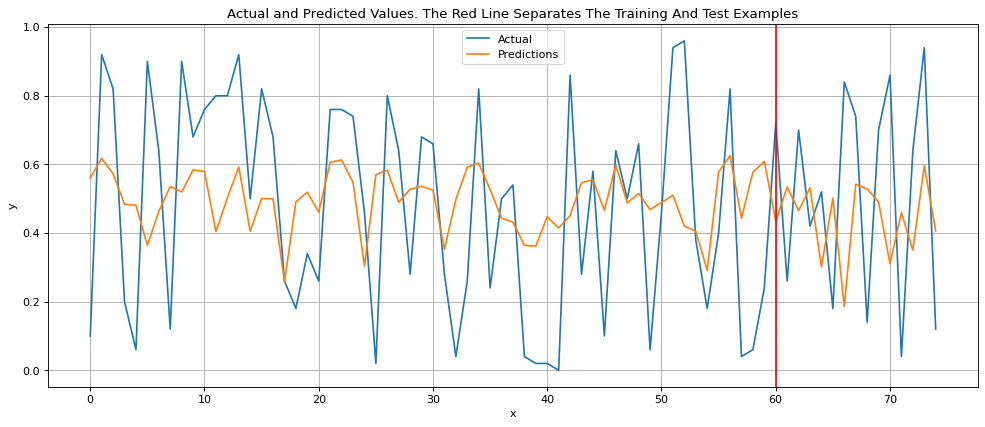

In [39]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
    plt.grid()
plot_result(trainY, testY, train_predict, test_predict)